In [44]:
library(ggplot2)
library(dplyr)
library(ggpmisc)
library(MASS)

# Generate Simulation Data

In [149]:
generate.data <- function(n, each, order = c(0,1,2), random = c(0,0,0,0)) {
    k.g <- 1
    k.h <- 2
    s <- ifelse(length(each) == 1, each, length(each))
    l <- ifelse(length(each) == 1, n*n*each, sum(each))
    if (length(each) == 1) {
        group <- rep(1:(n*n), each = each)
    } else {
        group <- rep(1:(n*n), each)
    }
    X <- mvrnorm(l, rep(0, k.g + k.h), diag(1, k.g + k.h, k.g + k.h))
    for (i in 1:(n*n)) {
        group.i <- which(group == i)
        X[group.i,1] <- mean(X[group.i,1])
    }
    X <- cbind(1, X)
    positions.data <- matrix(0, l, 2)
    positions.beta <- matrix(0, n*n, 2)
    for (i in 1:n) {
        for (j in 1:n) {
            p1 = (i - 1)*n + j
            positions.beta[p1,] = c(i,j)
            for (k in 1:each[p1]) {
                p2 = ifelse(p1 > 1, sum(each[1:(p1 - 1)]) + k, k)
                positions.data[p2,] = c(i,j)
            }
        }
    }
    beta.g <- matrix(0, n*n, k.g)
    for (i in 1:n) {
        for (j in 1:n) {
            p = (i - 1)*n + j
            beta = 0
            order.g = order[2]
            for (o1 in 0:order.g) {
                for (o2 in 0:order.g) {
                    set.seed(200 + i + j)
                    beta = beta + i^o1 * j^o2 #rnorm(1) * i^o1 * j^o2
                }
            }
            beta.g[p, 1] = 10 * beta / (n^(2*order.g))
        }
    }
    beta.g[, 1] = scale(beta.g[, 1] + random[2] * rnorm(n*n, sd = 0.1))
    beta.h <- matrix(0, n*n, k.h)
    for (i in 1:n) {
        for (j in 1:n) {
            p = (i - 1)*n + j
            beta = 0
            order.h = order[3]
            for (o1 in 0:order.h) {
                for (o2 in 0:order.h) {
                    set.seed(300 + i * n + j)
                    beta = beta + rnorm(1) * i^o1 * j^o2
                }
            }
            beta.h[p, 1] = beta / (n^(2*order.h))
        }
    }
    set.seed(12)
    beta.h[, 1] = scale(beta.h[, 1] + random[3] * rnorm(n*n, sd = 0.1))
    set.seed(13)
    beta.h[, 2] = 1 + random[4] * rnorm(n*n, sd = 1)
    beta.intercept <- numeric(n*n)
    for (i in 1:n) {
        for (j in 1:n) {
            p = (i - 1)*n + j
            beta = 0
            order.intercept = order[1]
            for (o1 in 0:order.intercept) {
                for (o2 in 0:order.intercept) {
                    set.seed(100 + i + j)
                    beta = beta + i^o1 * j^o2 #rnorm(1) * i^o1 * j^o2
                }
            }
            beta.intercept[p] = beta / (n^(2*order.intercept))
        }
    }
    set.seed(10)
    beta.intercept = scale(beta.intercept + random[1] * rnorm(n*n, sd = 0.1))
    beta <- cbind(beta.intercept, beta.g, beta.h)
    y <- numeric(l)
    for (i in 1:(n*n)) {
        beta.i <- beta[i,]
        group.i <- which(group == i)
        X.i <- X[group.i,]
        y[group.i] <- X.i %*% beta.i
    }
    y = y + rnorm(l)
    data <- as.data.frame(cbind(group, positions.data, y, X[,-1]))
    colnames(data) <- c("group", "lon", "lat", "y", paste0(rep("g", k.g), 1:k.g), paste0(rep("h", k.h), 1:k.h))
    beta <- as.data.frame(cbind(positions.beta, beta))
    colnames(beta) <- c("lon", "lat", "Intercept", paste0(rep("g", k.g), 1:k.g), paste0(rep("h", k.h), 1:k.h))
    list(
        data = data,
        beta = beta
    )
}

In [150]:
oi = 2
og = 2
oh = 2
ri = 0
rg = 0
rh1 = 1
rh2 = 0
set.seed(100)
gen.each <- floor(runif(15*15, min = 50, max = 100))
gen <- generate.data(15, gen.each, order = c(oi, og, oh), random = c(ri, rg, rh1, rh2))
data.group <- gen$data %>% group_by(group) %>% summarise(g1 = mean(g1), lon = mean(lon), lat = mean(lat)) %>% as.data.frame()

In [151]:
write.table(gen$data["y"], "../data/hlmgwr_y.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, gen$data[c("h1")]), "../data/hlmgwr_z.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, gen$data[c("h2")]), "../data/hlmgwr_x.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$data["group"] - 1, "../data/hlmgwr_group.csv", sep = ",", row.names = F, col.names = F)
write.table(data.group[c("lon", "lat")], "../data/hlmgwr_u.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, data.group["g1"]), "../data/hlmgwr_g.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$beta, "../data/hlmgwr_beta.csv", sep = ",", row.names = F, col.names = F)

In [152]:
write.table(gen$data["y"], "../data/hlm_y.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, gen$data[c("h1", "h2")]), "../data/hlm_x.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$data["group"] - 1, "../data/hlm_group.csv", sep = ",", row.names = F, col.names = F)
write.table(data.group[c("lon", "lat")], "../data/hlm_u.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, data.group["g1"]), "../data/hlm_g.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$beta, "../data/hlm_beta.csv", sep = ",", row.names = F, col.names = F)

# Check Results

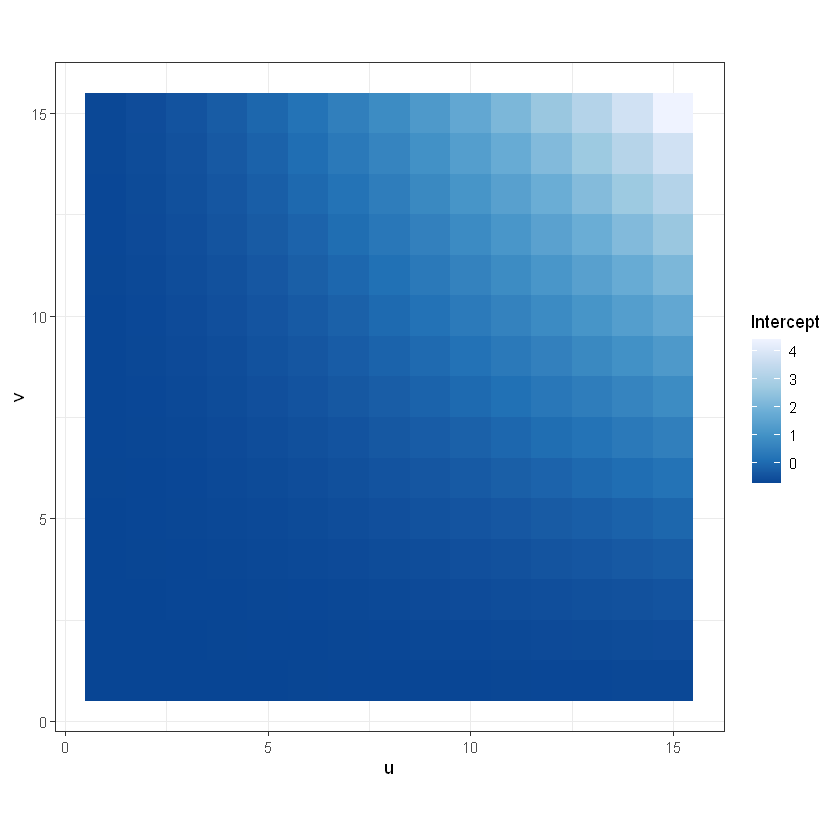

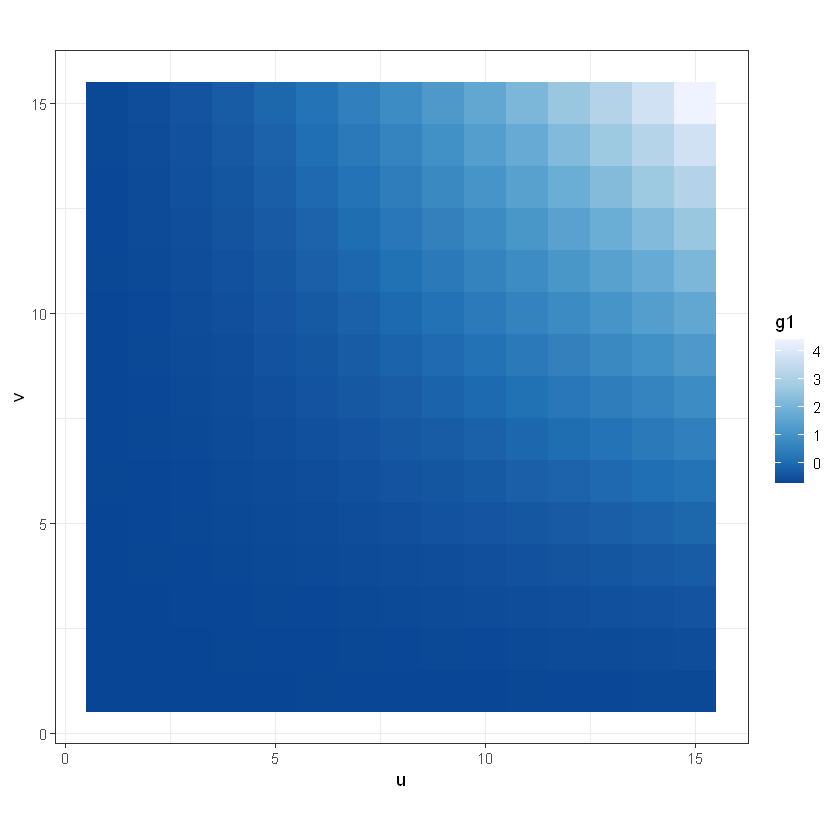

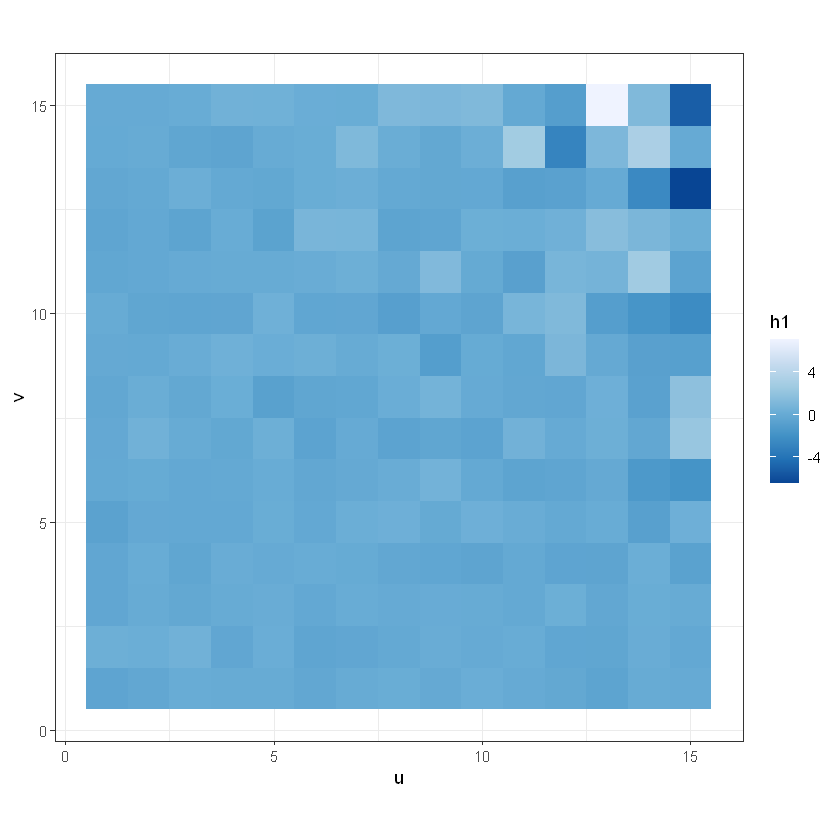

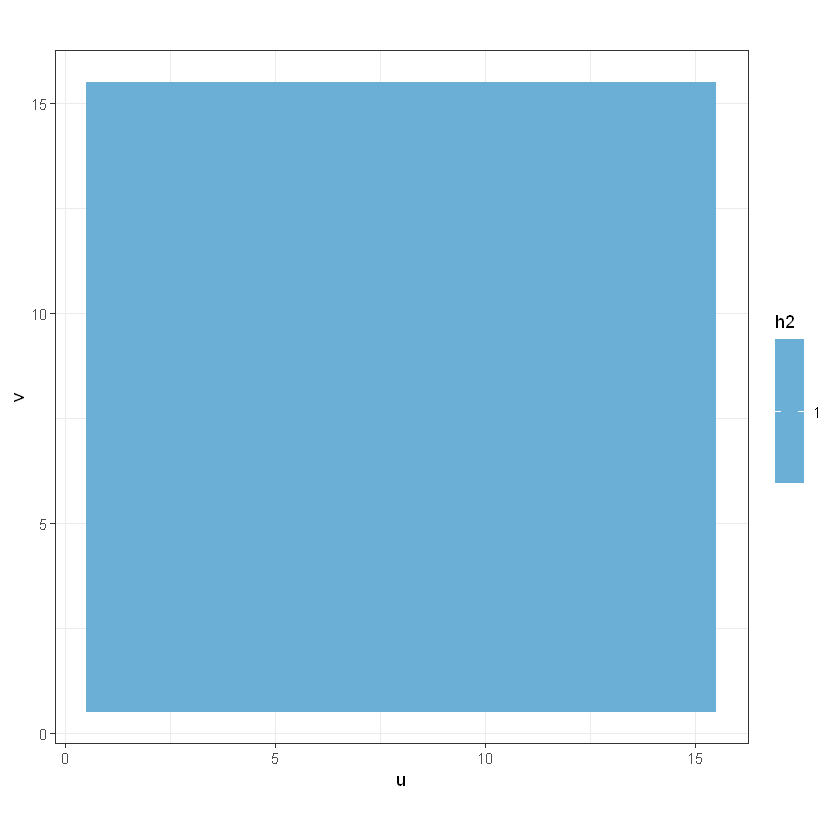

In [153]:
beta0 = read.csv("../data/hlmgwr_beta.csv", header = F)
colnames(beta0) <- c("u", "v", "Intercept", "g1", "h1", "h2")
beta0 %>%
    ggplot(aes(u, v, fill = Intercept)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()
beta0 %>%
    ggplot(aes(u, v, fill = g1)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()
beta0 %>%
    ggplot(aes(u, v, fill = h1)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()
beta0 %>%
    ggplot(aes(u, v, fill = h2)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()

## HLM

In [176]:
data.group <- read.csv("../data/hlm_group.csv", header = F)[[1]] + 1
hlm_data = cbind(
    read.csv("../data/hlm_y.csv", header = F),
    read.csv("../data/hlm_g.csv", header = F)[data.group,-1],
    read.csv("../data/hlm_x.csv", header = F)[,-1],
    data.group
)
colnames(hlm_data) <- c("y", "g1", "h1", "h2", "group")
hlm_model <- lmerTest::lmer(y ~ g1 + h1 + h2 + (g1 + h1 | group), hlm_data)
# summary(hlm_model)
performance::r2(hlm_model)
hlm_u <- read.csv("../data/hlm_u.csv", header = F)
hlm_beta <- cbind(hlm_u, coefficients(hlm_model)$group)
colnames(hlm_beta)[1:3] <- c("lon", "lat", "Intercept")

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"unable to evaluate scaled gradient"
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge: degenerate  Hessian with 1 negative eigenvalues"
Warning message:
"Model failed to converge with 1 negative eigenvalue: -1.4e+00"


# R2 for Mixed Models

  Conditional R2: 0.749
     Marginal R2: 0.240

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 2 rows containing non-finite values (stat_poly_eq)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 41 rows containing non-finite values (stat_poly_eq)."
Warning message:
"Removed 41 rows containing missing values (geom_point)."


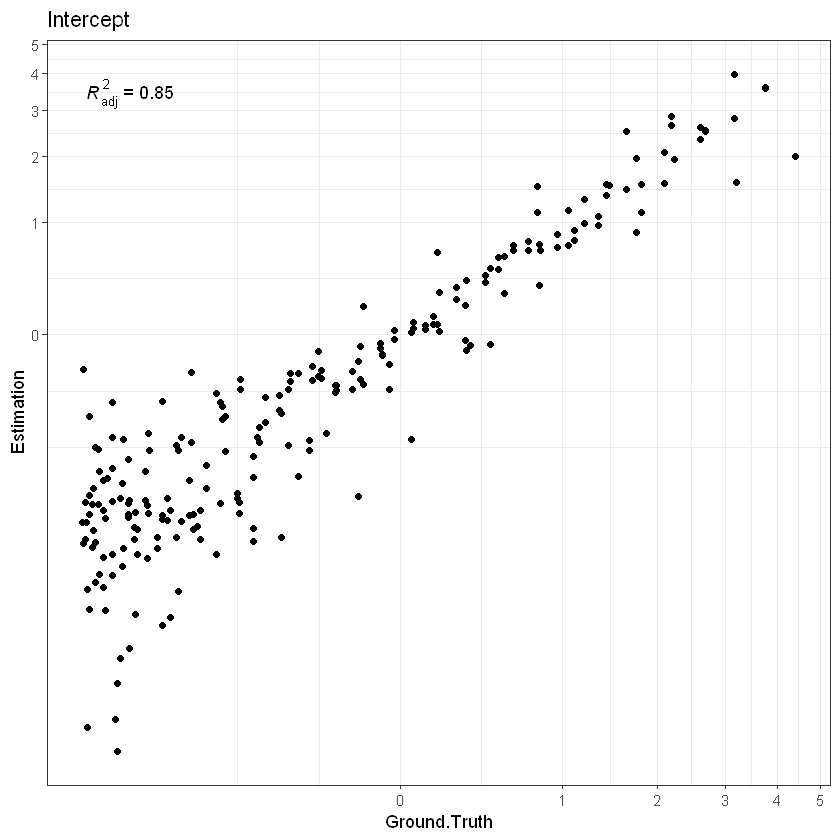

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 9 rows containing non-finite values (stat_poly_eq)."
Warning message:
"Removed 9 rows containing missing values (geom_point)."


[[1]]

[[2]]

[[3]]


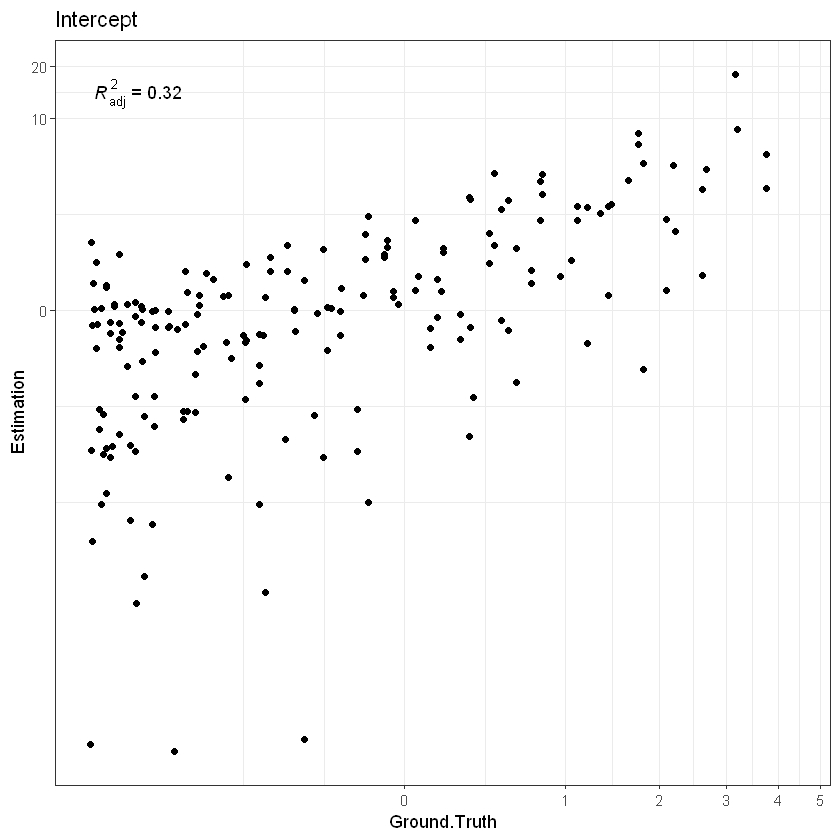

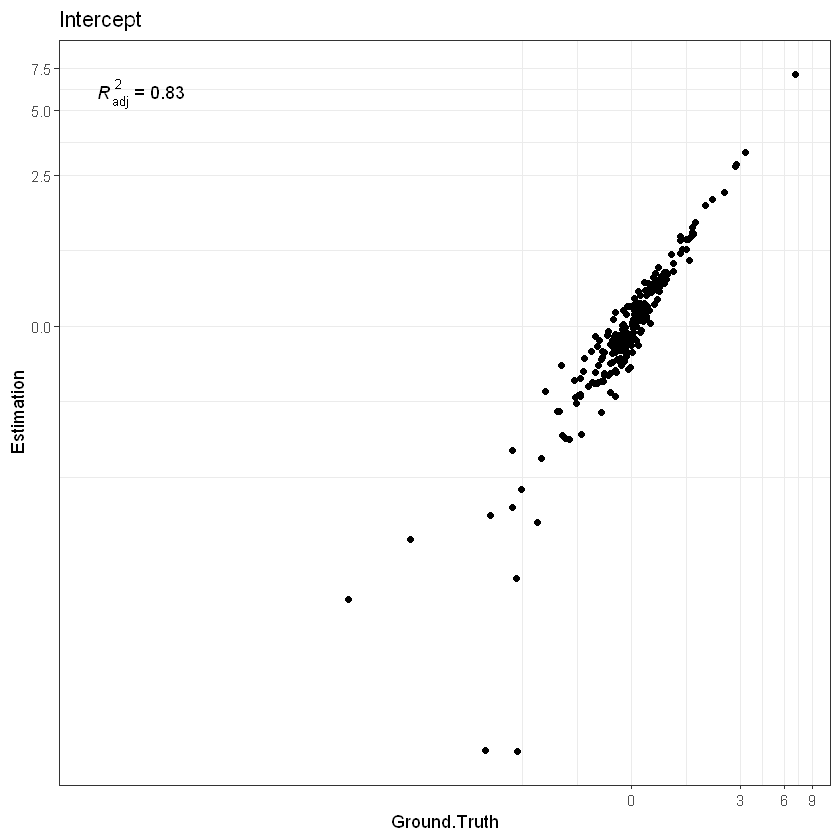

In [177]:
c("Intercept", "g1", "h1") %>% 
    lapply(function(var) {
        data.frame(Ground.Truth = beta0[[var]], Estimation = hlm_beta[[var]]) %>%
            ggplot(aes(Ground.Truth, Estimation)) +
            geom_point() +
            stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
            scale_x_continuous(trans = "log1p") +
            scale_y_continuous(trans = "log1p") +
            labs(title = "Intercept") +
            theme_bw()
    })

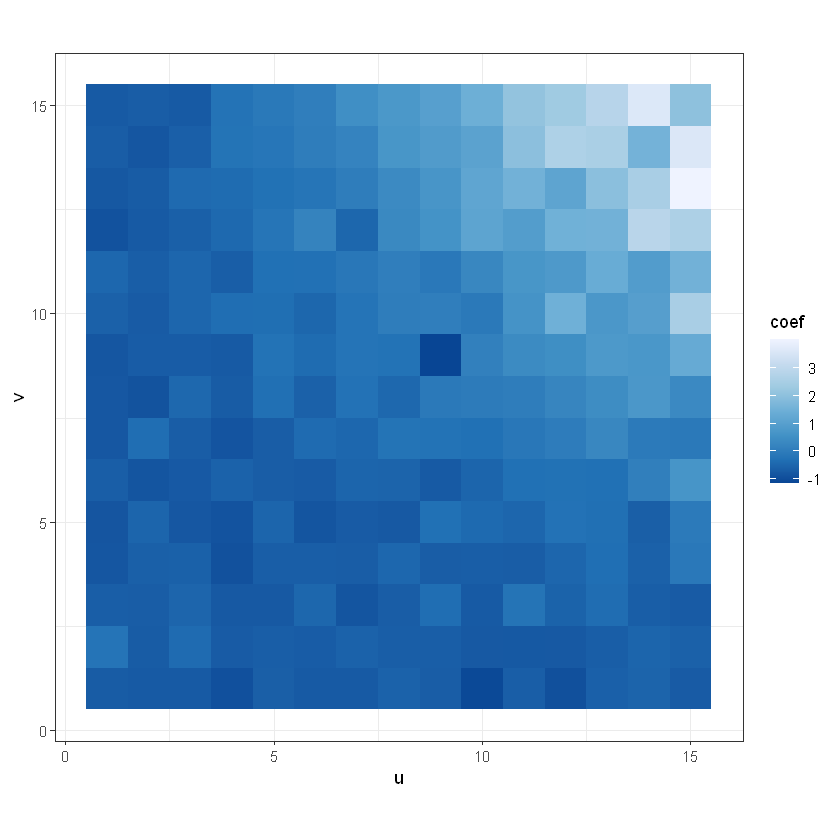

[[1]]

[[2]]

[[3]]


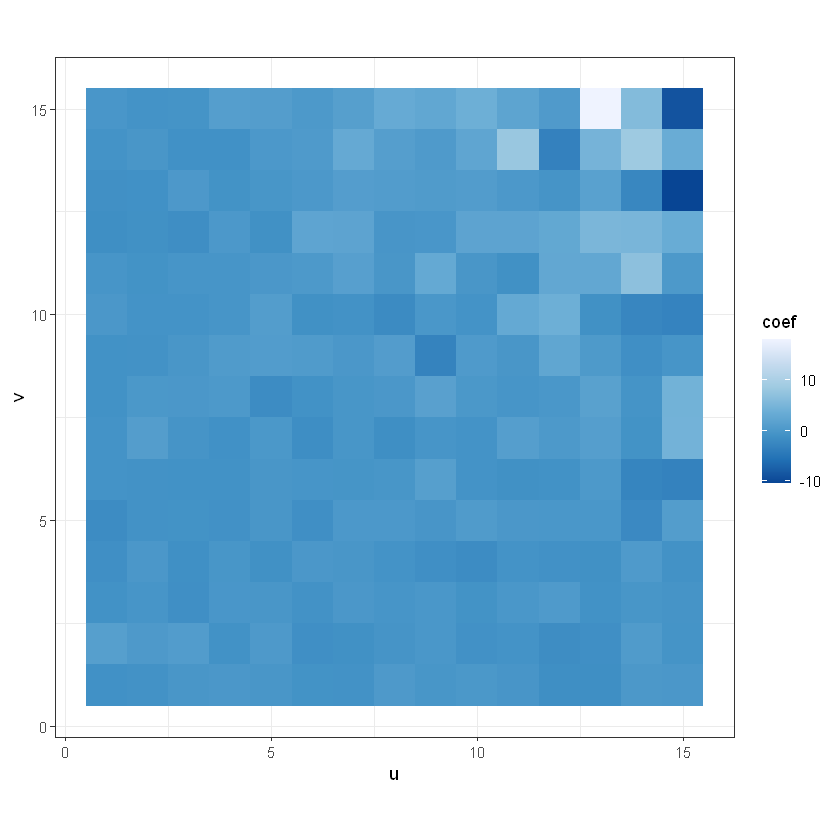

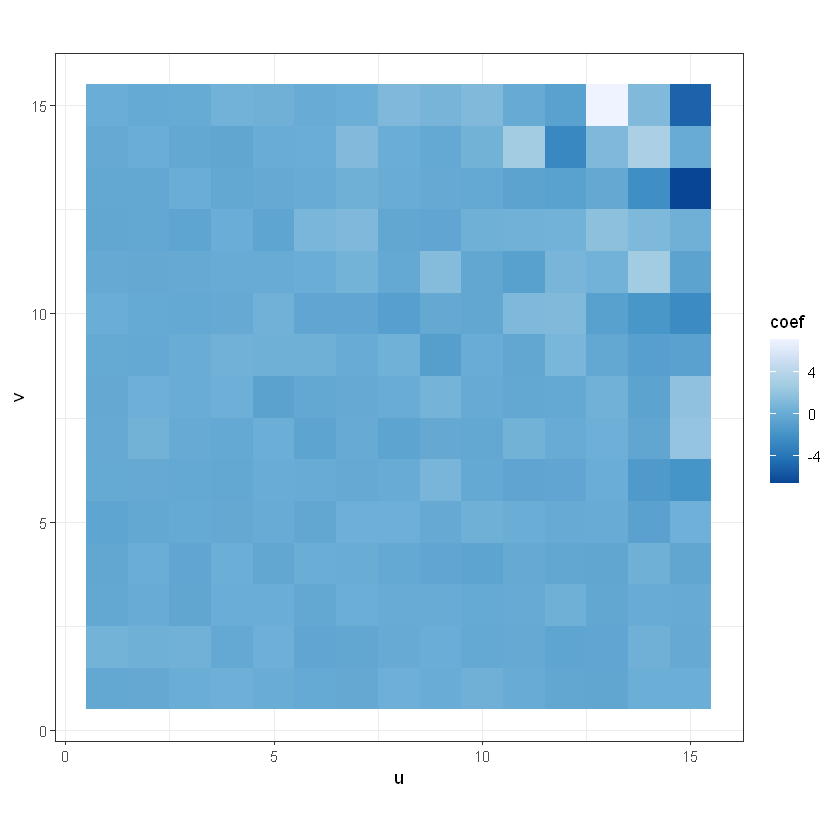

In [178]:
c("Intercept", "g1", "h1") %>% 
    lapply(function(var) {
        data.frame(u = hlm_beta$lon, v = hlm_beta$lat, coef = hlm_beta[[var]]) %>%
            ggplot(aes(u, v, fill = coef)) + 
            geom_tile() + scale_fill_distiller() + 
            coord_fixed() + 
            # facet_wrap(~Name, nrow = 1) + 
            theme_bw()
    })

## HLMGWR

In [171]:
hlmgwr_beta <- t(read.csv("../data/hlmgwr_hat_beta.csv", header = F)[1])
hlmgwr_gamma <- read.csv("../data/hlmgwr_hat_gamma.csv", header = F)
hlmgwr_mu <- read.csv("../data/hlmgwr_hat_mu.csv", header = F)
hlmgwr_u <- read.csv("../data/hlmgwr_u.csv", header = F)
hlmgwr_coef <- cbind(
    hlmgwr_u,
    Intercept = hlmgwr_gamma[,1] + hlmgwr_mu[,1] + hlmgwr_beta[1],
    hlmgwr_gamma[-1],
    hlmgwr_mu[-1],
    hlmgwr_beta[-1]
)
colnames(hlmgwr_coef) <- c("lon", "lat", "Intercept", "g1", "h1", "h2")

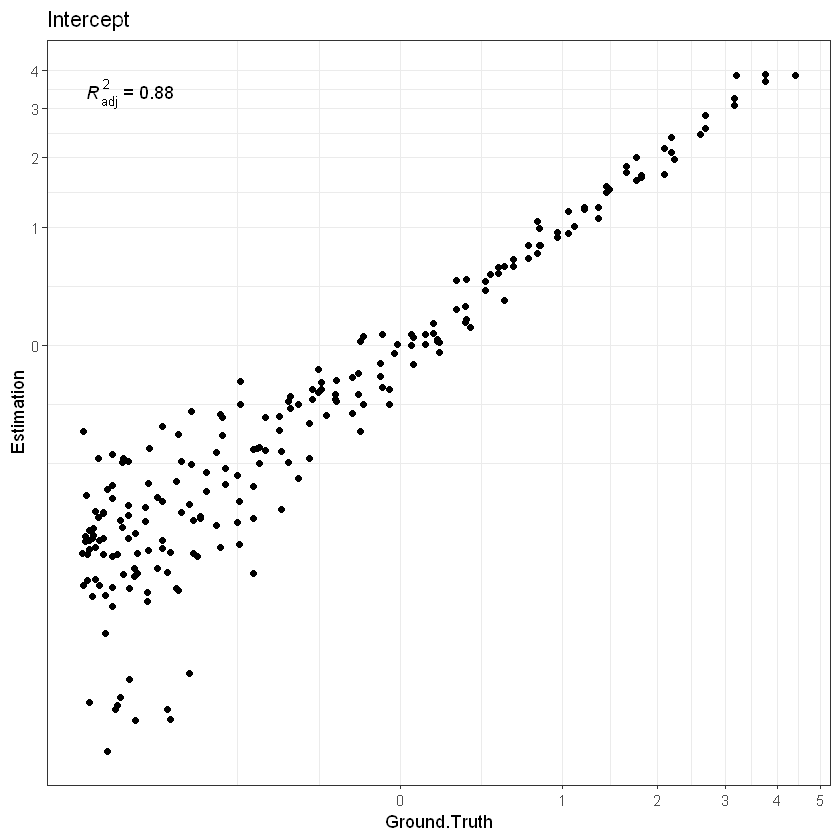

Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message in self$trans$transform(x):
"NaNs produced"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 9 rows containing non-finite values (stat_poly_eq)."
Warning message:
"Removed 9 rows containing missing values (geom_point)."


[[1]]

[[2]]

[[3]]


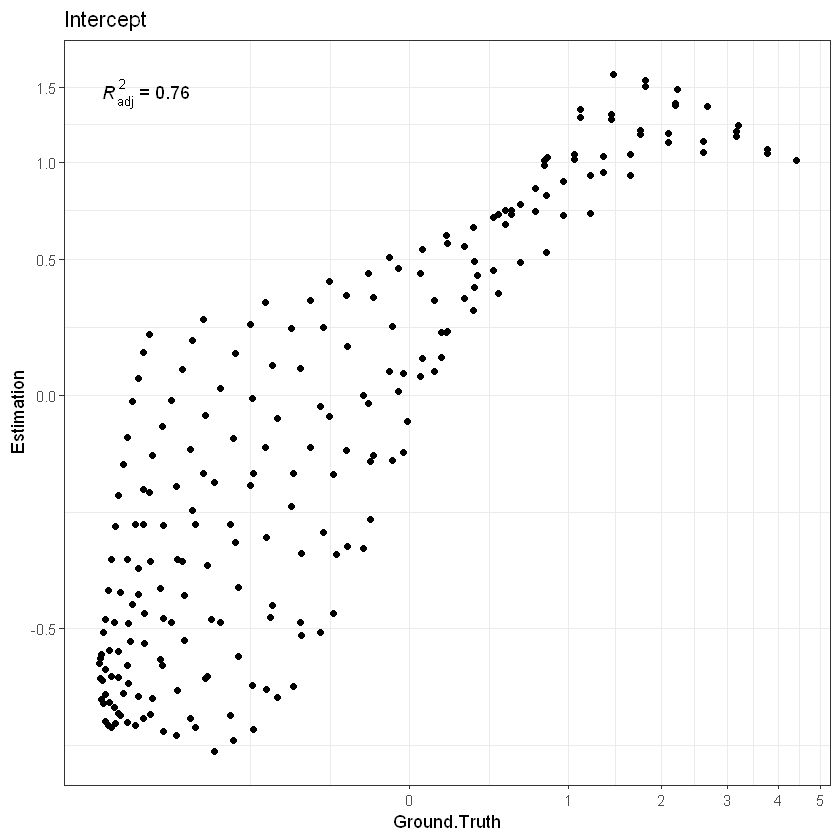

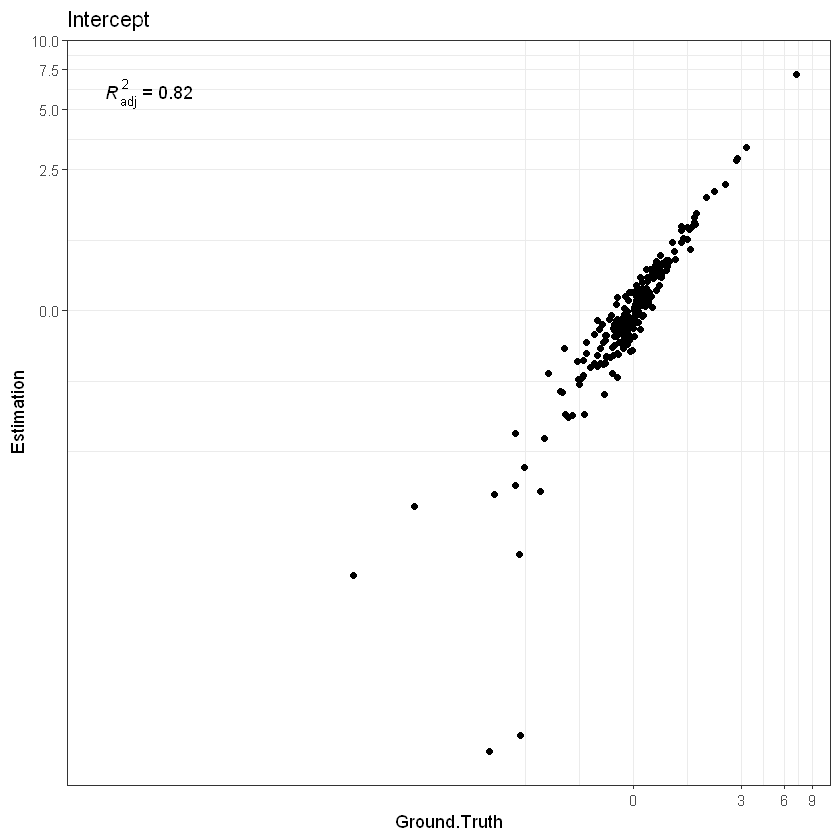

In [172]:
c("Intercept", "g1", "h1") %>% 
    lapply(function(var) {
        data.frame(Ground.Truth = beta0[[var]], Estimation = hlmgwr_coef[[var]]) %>%
            ggplot(aes(Ground.Truth, Estimation)) +
            geom_point() +
            stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
            scale_x_continuous(trans = "log1p") +
            scale_y_continuous(trans = "log1p") +
            labs(title = "Intercept") +
            theme_bw()
    })

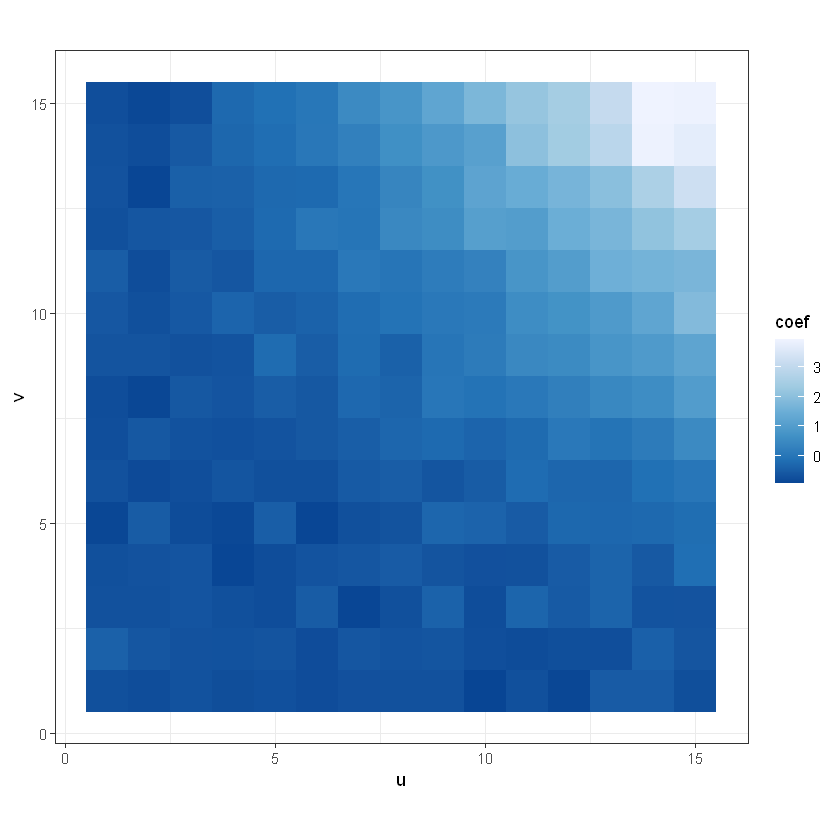

[[1]]

[[2]]

[[3]]


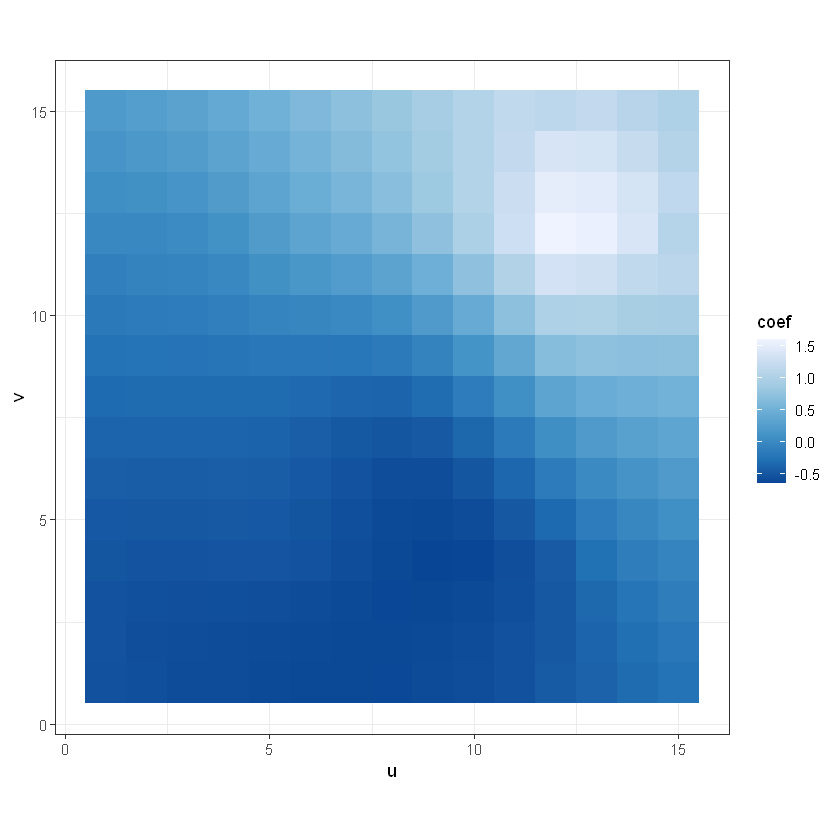

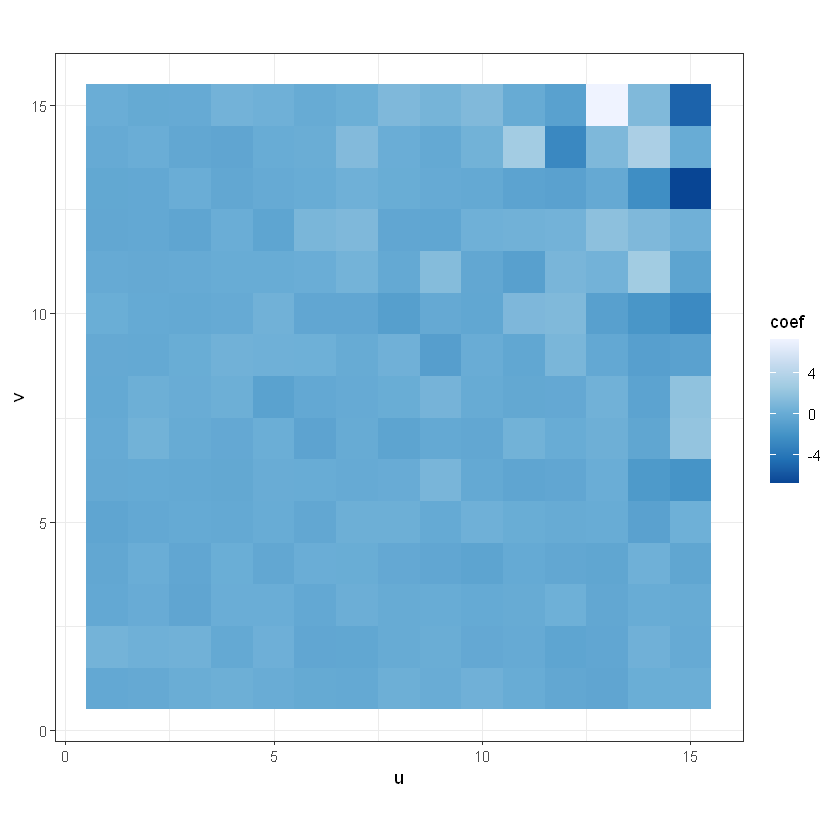

In [173]:
c("Intercept", "g1", "h1") %>% 
    lapply(function(var) {
        data.frame(u = hlmgwr_coef$lon, v = hlmgwr_coef$lat, coef = hlmgwr_coef[[var]]) %>%
            ggplot(aes(u, v, fill = coef)) + 
            geom_tile() + scale_fill_distiller() + 
            coord_fixed() + 
            # facet_wrap(~Name, nrow = 1) + 
            theme_bw()
    })

In [174]:
data.frame(
    HLM.Intercept = (abs((beta0$Intercept - hlm_beta$Intercept) / beta0$Intercept)),
    HLMGWR.Intercept = (abs((beta0$Intercept - hlmgwr_coef$Intercept) / beta0$Intercept)),
    HLM.g1 = (abs((beta0$g1 - hlm_beta$g1) / beta0$g1)),
    HLMGWR.g1 = (abs((beta0$Intercept - hlmgwr_coef$Intercept) / beta0$g1)),
    HLM.h1 = (abs((beta0$h1 - hlm_beta$h1) / beta0$h1)),
    HLMGWR.h1 = (abs((beta0$Intercept - hlmgwr_coef$Intercept) / beta0$h1)),
    HLM.h2 = (abs((beta0$h2 - hlm_beta$h2) / beta0$h2)),
    HLMGWR.h2 = (abs((beta0$h2 - hlmgwr_coef$h2) / beta0$h2))
) %>% lapply(fivenum) %>% as.data.frame(row.names = c("Min", "1st Quater", "Midean", "3st Quater", "Max")) %>% round(6)

,HLM.Intercept,HLMGWR.Intercept,HLM.g1,HLMGWR.g1,HLM.h1,HLMGWR.h1,HLM.h2,HLMGWR.h2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min,0.000479,0.001360,0.001178,0.001360,0.002441,0.007042,0.02205,0.022288
1st Quater,0.082377,0.062085,0.545654,0.062085,0.087217,0.108422,0.02205,0.022288
Midean,0.196263,0.133924,1.076489,0.133924,0.265838,0.266003,0.02205,0.022288
3st Quater,0.369218,0.298741,2.330301,0.298741,0.738402,0.685891,0.02205,0.022288
Max,104.541105,5.271860,283.955798,5.271860,136.537273,227.085379,0.02205,0.022288


In [175]:
data.frame(
    HLM.Intercept = ((beta0$Intercept - hlm_beta$Intercept)^2),
    HLMGWR.Intercept = ((beta0$Intercept - hlmgwr_coef$Intercept)^2),
    HLM.g1 = ((beta0$g1 - hlm_beta$g1)^2),
    HLMGWR.g1 = ((beta0$Intercept - hlmgwr_coef$g1)^2),
    HLM.h1 = ((beta0$h1 - hlm_beta$h1)^2),
    HLMGWR.h1 = ((beta0$Intercept - hlmgwr_coef$h1)^2),
    HLM.h2 = ((beta0$h2 - hlm_beta$h2)^2),
    HLMGWR.h2 = ((beta0$h2 - hlmgwr_coef$h2)^2)
) %>% lapply(fivenum) %>% as.data.frame(row.names = c("Min", "1st Quater", "Midean", "3st Quater", "Max")) %>% round(5)

,HLM.Intercept,HLMGWR.Intercept,HLM.g1,HLMGWR.g1,HLM.h1,HLMGWR.h1,HLM.h2,HLMGWR.h2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00002,0.00049,5e-04
1st Quater,0.00243,0.00167,0.08407,0.01159,0.00132,0.13947,0.00049,5e-04
Midean,0.01092,0.00698,0.38380,0.03738,0.00583,0.36227,0.00049,5e-04
3st Quater,0.03960,0.02398,1.40301,0.16085,0.02064,0.85817,0.00049,5e-04
Max,5.67888,0.45733,221.85199,11.43266,0.13447,96.99899,0.00049,5e-04
